In [24]:
! pip install -q kaggle
from google.colab import files

files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [26]:
# Import necessary modules
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob

In [27]:
# Provide image size, training, and testing data paths
IMAGESHAPE = [224, 224, 3]
training_data = '/content/chest_xray/train'
testing_data = '/content/chest_xray/test'

In [28]:
# Create VGG16 model with pre-trained weights from ImageNet
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

# Set all layers in the VGG model as non-trainable
for each_layer in vgg_model.layers:
    each_layer.trainable = False


In [29]:
# Find how many classes (categories) are present in the training dataset
classes = glob('/content/chest_xray/train/*')
classes
num_classes = len(classes)

In [30]:
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# Add custom layers on top of VGG16
x = vgg_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create the final model
final_model = Model(inputs=vgg_model.input, outputs=prediction)

# Summarize the model
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [31]:
# # Create the final model by combining VGG output and prediction
# final_model = Model(inputs=vgg_model.input, outputs=prediction)
# final_model.summary()

In [32]:
# Import necessary modules for additional metrics
from keras.metrics import Precision, Recall, AUC

# Compile the model using categorical crossentropy loss and Adam optimizer
final_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [33]:
# Import ImageDataGenerator for data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
testing_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
# Generate batches of augmented data from the training and testing datasets
training_set = train_datagen.flow_from_directory(
    training_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [35]:
test_set = testing_datagen.flow_from_directory(
    testing_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [43]:
# Train the model using fit_generator
fitted_model = final_model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


Epoch 1/10
163/163 [==============================] - 110s 674ms/step - loss: 0.1707 - accuracy: 0.9398 - precision: 0.9628 - recall: 0.9559 - auc: 0.9765 - val_loss: 0.2638 - val_accuracy: 0.9087 - val_precision: 0.8899 - val_recall: 0.9744 - val_auc: 0.9628
Epoch 2/10
163/163 [==============================] - 114s 701ms/step - loss: 0.1659 - accuracy: 0.9390 - precision: 0.9628 - recall: 0.9548 - auc: 0.9771 - val_loss: 0.2600 - val_accuracy: 0.9119 - val_precision: 0.9177 - val_recall: 0.9436 - val_auc: 0.9619
Epoch 3/10
163/163 [==============================] - 116s 711ms/step - loss: 0.1424 - accuracy: 0.9511 - precision: 0.9731 - recall: 0.9608 - auc: 0.9835 - val_loss: 0.2814 - val_accuracy: 0.9103 - val_precision: 0.8995 - val_recall: 0.9641 - val_auc: 0.9590
Epoch 4/10
163/163 [==============================] - 110s 673ms/step - loss: 0.1426 - accuracy: 0.9463 - precision: 0.9699 - recall: 0.9574 - auc: 0.9825 - val_loss: 0.3539 - val_accuracy: 0.8798 - val_precision: 0.8416

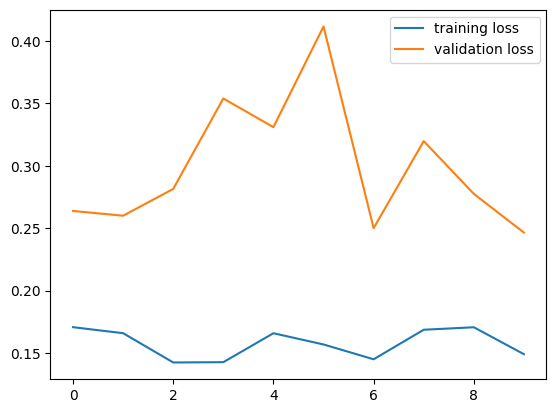

<Figure size 640x480 with 0 Axes>

In [44]:
# Plot and save the training and validation loss curves
plt.plot(fitted_model.history['loss'], label='training loss')
plt.plot(fitted_model.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

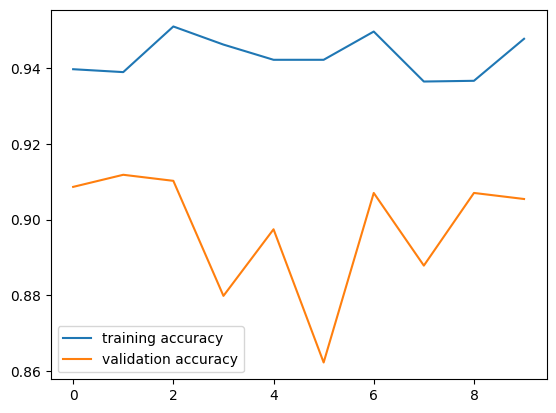

<Figure size 640x480 with 0 Axes>

In [45]:
# Plot and save the training and validation accuracy curves
plt.plot(fitted_model.history['accuracy'], label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [46]:
# Save the trained model
final_model.save('our_model.h5')


In [47]:
!pip install keras-preprocessing
# Load the trained model for testing
from keras_preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = load_model('our_model.h5')

In [48]:
# Load and preprocess a test image
img = image.load_img('/content/chest_xray/test/PNEUMONIA/person109_bacteria_519.jpeg', target_size=(224, 224))
image_data = image.img_to_array(img)
image_data = np.expand_dims(image_data, axis=0)
img_data = preprocess_input(image_data)


In [50]:
# Make predictions on the test image
prediction = model.predict(img_data)

# Print the prediction result
# if prediction[0][0] > prediction[0][1]:
#     print('Person is safe.')
# else:
#     print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')

1/1 [==============================] - 0s 48ms/step
Predictions: [[1.]]
